In [1]:
import os, glob
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import seaborn as sns
import edt
from cloudvolume import CloudVolume

%matplotlib inline

In [2]:
# Load in the Allen 16-bit annotation atlas
atlas_file = '/jukebox/LightSheetTransfer/atlas/allen_atlas/annotation_2017_25um_sagittal_16bit_hierarch_labels_fillmissing.tif'
atlas_vol = np.array(tifffile.imread(atlas_file)).astype('uint16')

In [3]:
atlas_vol.dtype

dtype('uint16')

In [4]:
atlas_vol.shape

(456, 528, 320)

In [5]:
atlas_vol_bool = atlas_vol.astype('bool')

In [10]:
# Calculate the Euclidean distance transform (EDT) which is how far from a 0 value each voxel is
anisotropy = (25,25,25) # resolution in microns in x,y,z so that the resulting edt array can be masked using microns
edt_allen_bool = edt.edt(
  atlas_vol_bool,anisotropy=anisotropy, 
  black_border=True, order='C',
  parallel=6 # number of threads, <= 0 sets to num cpu
)

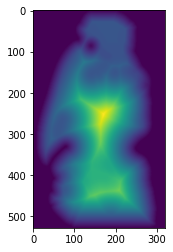

In [11]:
# Show Plane z=200 from the edt array - colormap indicates distance from edge
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.imshow(edt_allen_bool[200])

In [12]:
#zero out near edges
edge_microns_to_erode = 60 # min distance from edge something will be allowed
edge_mask = edt_allen_bool < edge_microns_to_erode

In [13]:
eroded_ann = atlas_vol.copy()

In [14]:
eroded_ann[edge_mask] = 0

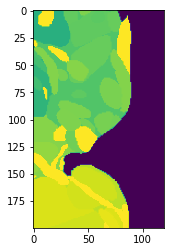

In [15]:
# Pre edge erosion
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.imshow(atlas_vol[200,200:400,200:400],vmin=0,vmax=1000)

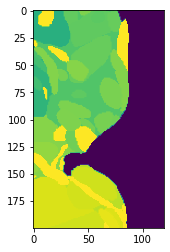

In [16]:
# Post edge erosion
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.imshow(eroded_ann[200,200:400,200:400],vmin=0,vmax=1000)

In [ ]:
# A little hard to see, but edge erosion worked

In [17]:
#get ventricles - these are the values of ventricles in the annotation image.
# They correspond to:
# VS: ventricular systems, VL: lateral ventricle, chpl: choroid plexus, chfl: choroid fissure,
# V3: third ventricle, V4: fourth ventricle


ventricle_values = [1306,1307,1310,1311,1313,1315]
ventricular_microns_to_erode = 80 # min distance from ventricle something will be allowed

In [18]:
#zero out near ventricles
# in order to do this we need a volume in which the ventricle regions are set to 0 (the reference value for the edt)
# and all other values are set to non-zero.

# First set all zero values to 1 (outside the volume either from before or from erosion in previous step)
vann = np.copy(eroded_ann)
vann[vann==0.0] = 1

In [19]:
# Now make a boolean mask finding where the ventricles are
vmask = np.isin(eroded_ann, ventricle_values)

In [20]:
# set values in vann where this mask applies to 0, the reference value for the edt
vann[vmask] = 0.0 #erode out nonventricular space adjacent to ventricles

In [21]:
# Make vann bool array so we can verify that the ventricle erosion worked
vann_bool = vann.astype('bool')

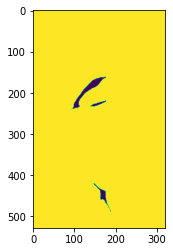

In [22]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.imshow(vann_bool[200,:,:])

In [23]:
# looks like it worked!

In [24]:
%%time
# now calculate the edt on this file to get an array of distances from the ventricles
anisotropy = (25,25,25) # resolution in microns in x,y,z according to edt docs
edt_ventricles = edt.edt(
  vann_bool,anisotropy=anisotropy, 
  black_border=True, order='C',
  parallel=6 # number of threads, <= 0 sets to num cpu
)

CPU times: user 18.8 s, sys: 3.37 s, total: 22.2 s
Wall time: 3.96 s


In [25]:
ventricle_mask = edt_ventricles < ventricular_microns_to_erode

In [26]:
eroded_ann[ventricle_mask] = 0

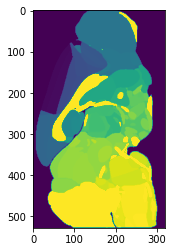

In [27]:
# Pre edge and ventricle erosion
plt.imshow(atlas_vol[200],vmin=0,vmax=1000)

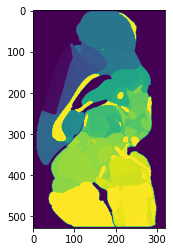

In [28]:
# Post edge and ventricle erosion
plt.imshow(eroded_ann[200],vmin=0,vmax=1000)

In [29]:
# Looks good. Let's save the eroded volume
savename = '/jukebox/LightSheetTransfer/atlas/allen_atlas/annotation_2017_25um_sagittal_16bit_hierarch_labels_fillmissing_60um_edge_80um_vent_erosion.tif'
tifffile.imsave(savename,eroded_ann)